In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ReadFromMySQLForexdb") \
    .config("spark.jars.packages", "mysql:mysql-connector-java:8.0.33") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "10000") \
    .config("spark.sql.execution.arrow.pyspark.memoryFraction", "0.5") \
    .getOrCreate()

jdbc_url = "jdbc:mysql://localhost:3306/forex_db"
forex_dates_table = "forex_dates"
forex_rates_table = "forex_rates"
properties = {
    "user": "root",
    "password": "rootpassword",
    "driver": "com.mysql.cj.jdbc.Driver"
}

forex_dates_df = spark.read.jdbc(url=jdbc_url, table=forex_dates_table, properties=properties)
forex_rates_df = spark.read.jdbc(url=jdbc_url, table=forex_rates_table, properties=properties)

forex_rates_df = forex_rates_df.filter(forex_rates_df.currency_iso.isin(['USD']))

forex_dates_df.show(2)
forex_rates_df.show(2)


data_df = forex_dates_df.join(forex_rates_df.drop("id"), forex_dates_df.id == forex_rates_df.forex_date_id,how="inner").orderBy(forex_rates_df.currency_iso)
# data_df.drop(forex_rates_df.id)

+---+----------+------------+-----------+
| id|      date|published_on|modified_on|
+---+----------+------------+-----------+
|  1|2022-01-01|  2022-01-01| 2021-12-31|
|  2|2022-01-02|  2022-01-02| 2021-12-31|
+---+----------+------------+-----------+
only showing top 2 rows

+---+-------------+-------------+------------+-------------+--------+---------+
| id|forex_date_id|currency_name|currency_iso|currency_unit|buy_rate|sell_rate|
+---+-------------+-------------+------------+-------------+--------+---------+
|  2|            1|  U.S. Dollar|         USD|            1|  118.64|   119.24|
| 24|            2|  U.S. Dollar|         USD|            1|  118.64|   119.24|
+---+-------------+-------------+------------+-------------+--------+---------+
only showing top 2 rows



In [4]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [19]:
data_df = data_df.filter(data_df["currency_iso"]=="USD")
data_df = data_df.orderBy("date")
# data_df.show(10)

In [6]:
import pmdarima as pm

/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1415.963, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1411.686, Time=0.15 sec


/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1410.605, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1410.526, Time=0.15 sec


/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1414.266, Time=0.09 sec


/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1411.967, Time=0.80 sec


/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1411.922, Time=0.36 sec


/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1413.850, Time=1.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1413.370, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.641 seconds
Forecast for next 30 days: 4187    138.255547
4188    138.265011
4189    138.274476
4190    138.283940
4191    138.293405
4192    138.302869
4193    138.312334
4194    138.321798
4195    138.331263
4196    138.340727
4197    138.350191
4198    138.359656
4199    138.369120
4200    138.378585
4201    138.388049
4202    138.397514
4203    138.406978
4204    138.416442
4205    138.425907
4206    138.435371
4207    138.444836
4208    138.454300
4209    138.463765
4210    138.473229
4211    138.482693
4212    138.492158
4213    138.501622
4214    138.511087
4215    138.520551
4216    138.530016
dtype: float64


/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rohitkarki/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


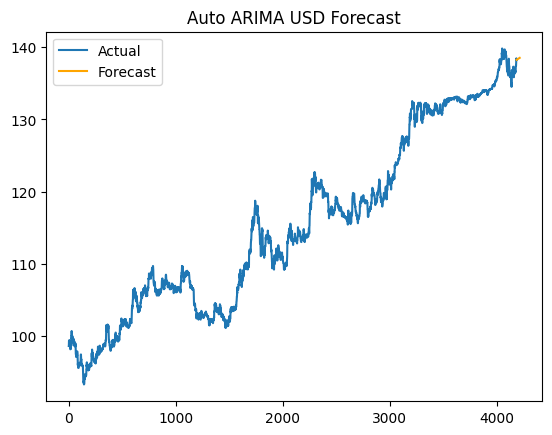

In [21]:
df = data_df.toPandas()
series = df['buy_rate'].reset_index(drop=True)

# Fit Auto ARIMA
model = pm.auto_arima(series, seasonal=False, trace=True)

# Forecast next 30 days
n_periods = 30
forecast = model.predict(n_periods=n_periods)
print(f"Forecast for next {n_periods} days: {forecast}")

# Plot
plt.plot(series, label='Actual')
plt.plot(range(len(series), len(series)+n_periods), forecast, label='Forecast', color='orange')
plt.legend()
plt.title("Auto ARIMA USD Forecast")
plt.show()

In [28]:
df = data_df.withColumn("year", F.year("date")) \
       .withColumn("month", F.month("date")) \
       .withColumn("day", F.dayofmonth("date")) \
       .withColumn("dayofweek", F.dayofweek("date")) \
       .withColumn("is_weekend", F.when(F.dayofweek("date").isin([1, 7]), 1).otherwise(0))


window = Window.partitionBy("currency_iso").orderBy("date")

df = df.withColumn("buy_rate_lag1", F.lag("buy_rate", 1).over(window)) \
       .withColumn("buy_rate_lag7", F.lag("buy_rate", 7).over(window)) \
       .withColumn("buy_rate_diff1", F.col("buy_rate") - F.col("buy_rate_lag1")) \
       .withColumn("buy_rate_diff7", F.col("buy_rate") - F.col("buy_rate_lag7"))

df = df.withColumn("buy_rate_roll_mean_3", F.avg("buy_rate").over(window.rowsBetween(-2, 0))) \
        .withColumn("buy_rate_roll_std_3", F.stddev("buy_rate").over(window.rowsBetween(-2, 0)))

df = df.withColumn("spread", F.col("sell_rate") - F.col("buy_rate"))
df = df.withColumn("buy_rate_pct_change", 
                   ((F.col("buy_rate") - F.col("buy_rate_lag1")) / F.col("buy_rate_lag1")) * 100)
df = df.drop(forex_dates_df.id)

df.show(10)

+----------+------------+-----------+-------------+-------------+------------+-------------+--------+---------+----+-----+---+---------+----------+-------------+-------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+
|      date|published_on|modified_on|forex_date_id|currency_name|currency_iso|currency_unit|buy_rate|sell_rate|year|month|day|dayofweek|is_weekend|buy_rate_lag1|buy_rate_lag7|      buy_rate_diff1|      buy_rate_diff7|buy_rate_roll_mean_3|buy_rate_roll_std_3|            spread| buy_rate_pct_change|
+----------+------------+-----------+-------------+-------------+------------+-------------+--------+---------+----+-----+---+---------+----------+-------------+-------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+
|2014-01-01|  2014-01-01| 2020-01-03|         4187|  U.S. Dollar|         USD|            1|   98.59|  

In [29]:
print(df.count())
df = df.dropna()
print(df.count())

4187
4180


In [9]:
print(df.columns)

['date', 'published_on', 'modified_on', 'forex_date_id', 'currency_name', 'currency_iso', 'currency_unit', 'buy_rate', 'sell_rate', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'buy_rate_lag1', 'buy_rate_lag7', 'buy_rate_diff1', 'buy_rate_diff7', 'buy_rate_roll_mean_3', 'buy_rate_roll_std_3', 'spread', 'buy_rate_pct_change']


In [30]:
feature_cols = [
    'year', 'month', 'day', 'dayofweek', 'is_weekend',
    'buy_rate_lag1', 'buy_rate_lag7',
    'buy_rate_roll_mean_3', 'buy_rate_roll_std_3',
    'buy_rate_diff1', 'buy_rate_diff7',
    'spread', 'buy_rate_pct_change'
]

df = df.toPandas()

df['target_buy_rate'] = df['buy_rate'].shift(-1) 

for lag in [1, 2, 3, 5, 7, 14]:
    df[f'buy_rate_lag{lag}'] = df['buy_rate'].shift(lag)


df = df.dropna().reset_index(drop=True)

X = df[feature_cols]
y = df['target_buy_rate']

MAE: 2.040525210084039


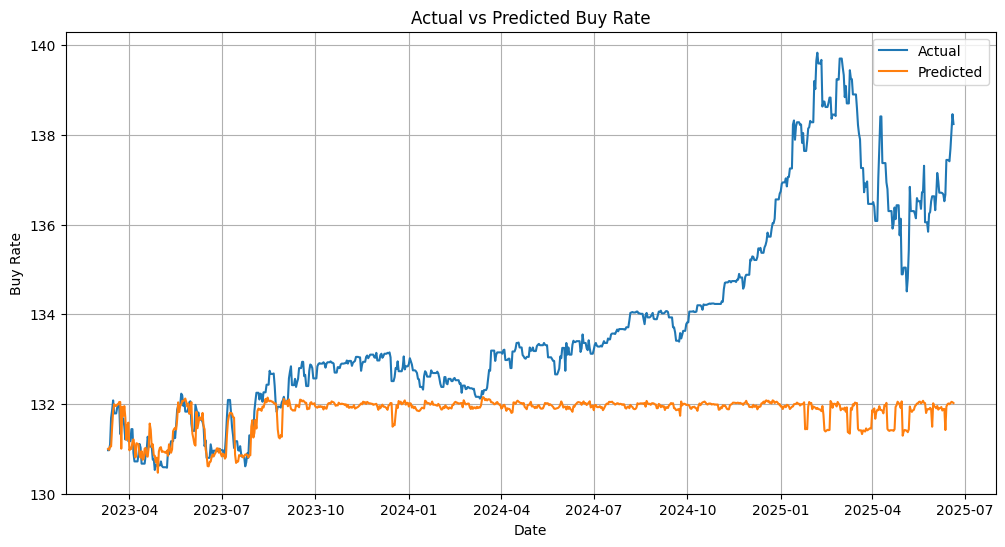

y test and y pred side by side is :[(130.97, 130.9988999999999), (130.97, 130.97839999999994), (131.1, 131.0553999999999), (131.69, 131.05249999999995), (131.86, 131.47920000000002), (132.08, 131.83880000000008), (131.79, 131.99400000000006), (131.79, 131.9587), (131.79, 131.9542000000001), (131.92, 131.98810000000006), (131.96, 131.99060000000011), (131.96, 132.0441), (131.33, 132.0442), (131.68, 131.00399999999996), (131.68, 131.93570000000005), (131.68, 131.73430000000002), (131.5, 131.9525), (131.21, 131.70380000000003), (131.45, 131.19929999999997), (131.45, 131.51870000000008), (131.17, 131.58509999999998), (131.17, 130.96620000000004), (131.17, 131.02490000000003), (131.44, 130.99750000000003), (131.44, 131.15390000000008), (130.91, 131.2123), (130.72, 131.06190000000004), (130.72, 130.80870000000002), (130.72, 131.12519999999992), (130.72, 131.11349999999996), (130.88, 131.10129999999998), (131.11, 130.87019999999998), (131.03, 130.80470000000003), (130.67, 130.94759999999994),

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# print("X_train :", X_train)
# print("X_test :", X_test)
# 13. Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 14. Predict
y_pred = model.predict(X_test)

# 15. Evaluation
print("MAE:", mean_absolute_error(y_test, y_pred))
# print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# 16. Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(df['date'].iloc[y_test.index], y_test, label='Actual')
plt.plot(df['date'].iloc[y_test.index], y_pred, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Buy Rate")
plt.xlabel("Date")
plt.ylabel("Buy Rate")
plt.grid()
plt.show()


print(f"y test and y pred side by side is :{list(zip(y_test, y_pred))}")

In [37]:
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# y_pred = np.array(y_pred)

# y_test = np.array(y_test)

# # Metrics
# mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred)  # squared=False gives RMSE
# r2 = r2_score(y_test, y_pred)

# print(f"MAE: {mae:.4f}")
# print(f"RMSE: {rmse:.4f}")
# print(f"R² Score: {r2:.4f}")

In [39]:
df['baseline_pred'] = df['buy_rate'].shift(1)

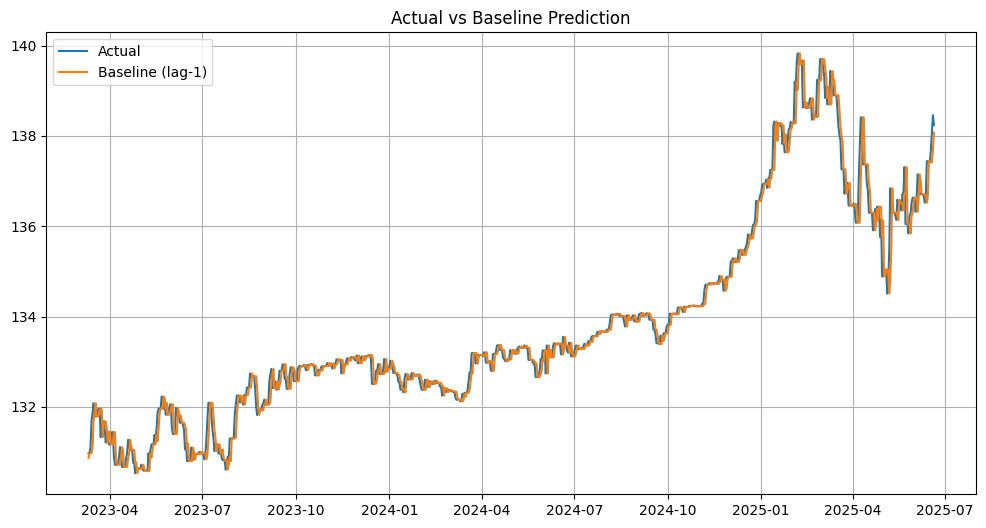

In [40]:
plt.figure(figsize=(12,6))
plt.plot(df['date'].iloc[y_test.index], y_test, label='Actual')
plt.plot(df['date'].iloc[y_test.index], df['baseline_pred'].iloc[y_test.index], label='Baseline (lag-1)')
plt.legend()
plt.title("Actual vs Baseline Prediction")
plt.grid()
plt.show()

In [ ]:
spark.stop()